In [1]:
import numpy as np
from sklearn.neighbors import KDTree
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import time
import random
import sys
import psutil

# **DATASET**

In [2]:
# Create the initial dataset with a large enough number of samples and dimensions
initial_dataset = np.random.rand(20000, 20)  # Starting with maximum required size and dimensions

# Function to generate datasets with varying sizes
def generate_datasets_by_size(dataset, min_size=1000, max_size=20000, step=500):
    """
    Generates datasets with sizes ranging from min_size to max_size in steps of `step`
    by slicing the initial dataset.
    """
    datasets_by_size = [dataset[:size, :] for size in range(min_size, max_size + 1, step)]
    return datasets_by_size

# Function to generate datasets with varying dimensions
def generate_datasets_by_dimension(dataset, min_dim=2, max_dim=20):
    """
    Generates datasets with dimensions ranging from min_dim to max_dim
    by slicing the initial dataset.
    """
    datasets_by_dimension = [dataset[:, :dim] for dim in range(min_dim, max_dim + 1)]
    return datasets_by_dimension


# Generate datasets by size and dimension
datasets_by_size = generate_datasets_by_size(initial_dataset)
datasets_by_dimension = generate_datasets_by_dimension(initial_dataset)

# Displaying the shapes of the datasets
print("\nDatasets by size (samples vary):")
for i, dataset in enumerate(datasets_by_size, start=1):
    print(f"Dataset {i}: {dataset.shape[0]} samples, {dataset.shape[1]} dimensions")

print("\nDatasets by dimension (dimensions vary):")
for i, dataset in enumerate(datasets_by_dimension, start=1):
    print(f"Dataset {i}: {dataset.shape[0]} samples, {dataset.shape[1]} dimensions")



Datasets by size (samples vary):
Dataset 1: 1000 samples, 20 dimensions
Dataset 2: 1500 samples, 20 dimensions
Dataset 3: 2000 samples, 20 dimensions
Dataset 4: 2500 samples, 20 dimensions
Dataset 5: 3000 samples, 20 dimensions
Dataset 6: 3500 samples, 20 dimensions
Dataset 7: 4000 samples, 20 dimensions
Dataset 8: 4500 samples, 20 dimensions
Dataset 9: 5000 samples, 20 dimensions
Dataset 10: 5500 samples, 20 dimensions
Dataset 11: 6000 samples, 20 dimensions
Dataset 12: 6500 samples, 20 dimensions
Dataset 13: 7000 samples, 20 dimensions
Dataset 14: 7500 samples, 20 dimensions
Dataset 15: 8000 samples, 20 dimensions
Dataset 16: 8500 samples, 20 dimensions
Dataset 17: 9000 samples, 20 dimensions
Dataset 18: 9500 samples, 20 dimensions
Dataset 19: 10000 samples, 20 dimensions
Dataset 20: 10500 samples, 20 dimensions
Dataset 21: 11000 samples, 20 dimensions
Dataset 22: 11500 samples, 20 dimensions
Dataset 23: 12000 samples, 20 dimensions
Dataset 24: 12500 samples, 20 dimensions
Dataset 2

# Distance

In [3]:
def pairwise_dist_naive(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)

    Returns the Euclidean distance between x and y
    """
    d = len(x)
    assert d == len(y)
    sqrd_distance = 0.0
    for i in range(d):
        sqrd_distance += (x[i] - y[i])**2
    return np.sqrt(sqrd_distance)


In [4]:
def pairwise_dist_numpy(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)

    Returns the Euclidean distance between x and y
    """
    return np.sqrt(np.sum((x - y)**2))


In [5]:
def pairwise_dist_numpy_norm(x: np.ndarray, y: np.ndarray) -> float:
    """
    x: numpy array of shape (d,)
    y: numpy array of shape (d,)

    Returns the Euclidean distance between x and y
    """
    return np.linalg.norm(x - y)


> **Speed:**   *pairwise_dist_numpy_norm > pairwise_dist_numpy > pairwise_dist_naive*

In [6]:
def distance_vector(X: np.ndarray, query_pt: np.ndarray) -> np.ndarray:
    """
    X: numpy array of shape (n, d)
    query_pt: numpy array of shape (d,)

    Returns the Euclidean distance between query_pt and each point in X
    """

    distances = np.linalg.norm(X - query_pt, axis=1)
    return distances

# **Naive Verision of KNN**

In [7]:
def naive_KNN(datasets, k, query_point):  # Overall Time Complexity: O(N * d)
    test_time = []
    K_nearest_points_list = []
    
    for dataset in datasets:
        n, d = dataset.shape
        
        start_time = time.time()
        distances = np.zeros(n)
        
        # Compute distances - Time Complexity: O(N * d)
        for i in range(n): 
            distances[i] = pairwise_dist_naive(dataset[i], query_point)  # O(d) per point
        
        # Find K smallest distances - Time Complexity: O(N)
        nearest_indices = np.argpartition(distances, k)[:k]  # Partial sort to get K nearest indices
        
        K_nearest_points = dataset[nearest_indices]  # Access K nearest points
        
        testing_time = time.time() - start_time
        test_time.append(testing_time)
#         print("samples-", n, "  dimension-", d, "  time-", testing_time)

        
        K_nearest_points_list.append(K_nearest_points)
        
    return test_time, K_nearest_points_list  # Total Complexity per dataset: O(N * d)

def calculate_memory_usage(dataset, nearest_points, distances):
    # Calculate memory usage of dataset (depends on number of points and dimensions)
    dataset_memory = dataset.nbytes  # This should already scale with both N and D
    
    # Calculate memory for K nearest points and distances
    nearest_points_memory = nearest_points.nbytes if isinstance(nearest_points, np.ndarray) else np.array(nearest_points).nbytes
    distances_memory = distances.nbytes if isinstance(distances, np.ndarray) else np.array(distances).nbytes
    
    # Total memory usage
    total_memory = dataset_memory + nearest_points_memory + distances_memory
    return total_memory



- **`np.argsort`**: Fully sorts the entire array, making the time complexity $( O(N \log N) )$.
- **`np.argpartition`**: Partially sorts the array, bringing only the $( K )$ elements of interest to the front. This operation has an average time complexity of $( O(N) )$.


In [8]:
query_point_size = np.random.rand(initial_dataset.shape[1])  # Matches initial dataset dimension for size test

# Running Naive KNN on datasets with varying sizes
print("Running Naive KNN on datasets with varying sizes:\n")
test_times_size, k_nearest_points_size = naive_KNN(datasets_by_size, k=3, query_point=query_point_size)

# Calculate memory usage for datasets with varying sizes
total_memory_used_size = []
for i, dataset in enumerate(datasets_by_size):
    total_memory = calculate_memory_usage(dataset, k_nearest_points_size[i], np.zeros(dataset.shape[0]))
    total_memory_used_size.append(total_memory)

# Run Naive KNN on datasets with varying dimensions
print("\nRunning Naive KNN on datasets with varying dimensions:\n")
test_times_dim = []
k_nearest_points_dim = []
total_memory_used_dim = []

# Loop over datasets with varying dimensions to generate query points for each dataset
for i, dataset in enumerate(datasets_by_dimension):
    query_point_dim = np.random.rand(dataset.shape[1])  # Generate query point with the same dimension as the dataset
    time_taken, nearest_points = naive_KNN([dataset], k=3, query_point=query_point_dim)  # Run KNN for the specific dataset
    test_times_dim.append(time_taken[0])  # Store the time taken for this dataset
    k_nearest_points_dim.append(nearest_points[0])  # Store the K nearest points for this dataset
    total_memory = calculate_memory_usage(dataset, k_nearest_points_dim[i], np.zeros(dataset.shape[0]))
    total_memory_used_dim.append(total_memory)  # Store the memory used for this dataset

# You can print or analyze the results
print(f"\nTest Times for Different Sizes: {test_times_size}")
print(f"Test Times for Different Dimensions: {test_times_dim}")
print(f"Memory Used for Different Sizes: {total_memory_used_size}")
print(f"Memory Used for Different Dimensions: {total_memory_used_dim}")

Running Naive KNN on datasets with varying sizes:


Running Naive KNN on datasets with varying dimensions:


Test Times for Different Sizes: [0.024551868438720703, 0.03283548355102539, 0.0436398983001709, 0.054010868072509766, 0.06518340110778809, 0.07404041290283203, 0.08571147918701172, 0.11220717430114746, 0.11228108406066895, 0.11644101142883301, 0.1283731460571289, 0.145888090133667, 0.15020155906677246, 0.16293621063232422, 0.17249059677124023, 0.18197965621948242, 0.19069671630859375, 0.20773077011108398, 0.21517324447631836, 0.23332452774047852, 0.23783183097839355, 0.24731802940368652, 0.26316308975219727, 0.30202507972717285, 0.2754697799682617, 0.387256383895874, 0.35134053230285645, 0.3302030563354492, 0.36482739448547363, 0.3312067985534668, 0.3410186767578125, 0.3514974117279053, 0.35835814476013184, 0.37769484519958496, 0.3799886703491211, 0.3902459144592285, 0.4127054214477539, 0.4373128414154053, 0.43196868896484375]
Test Times for Different Dimensions: [0.106538295745

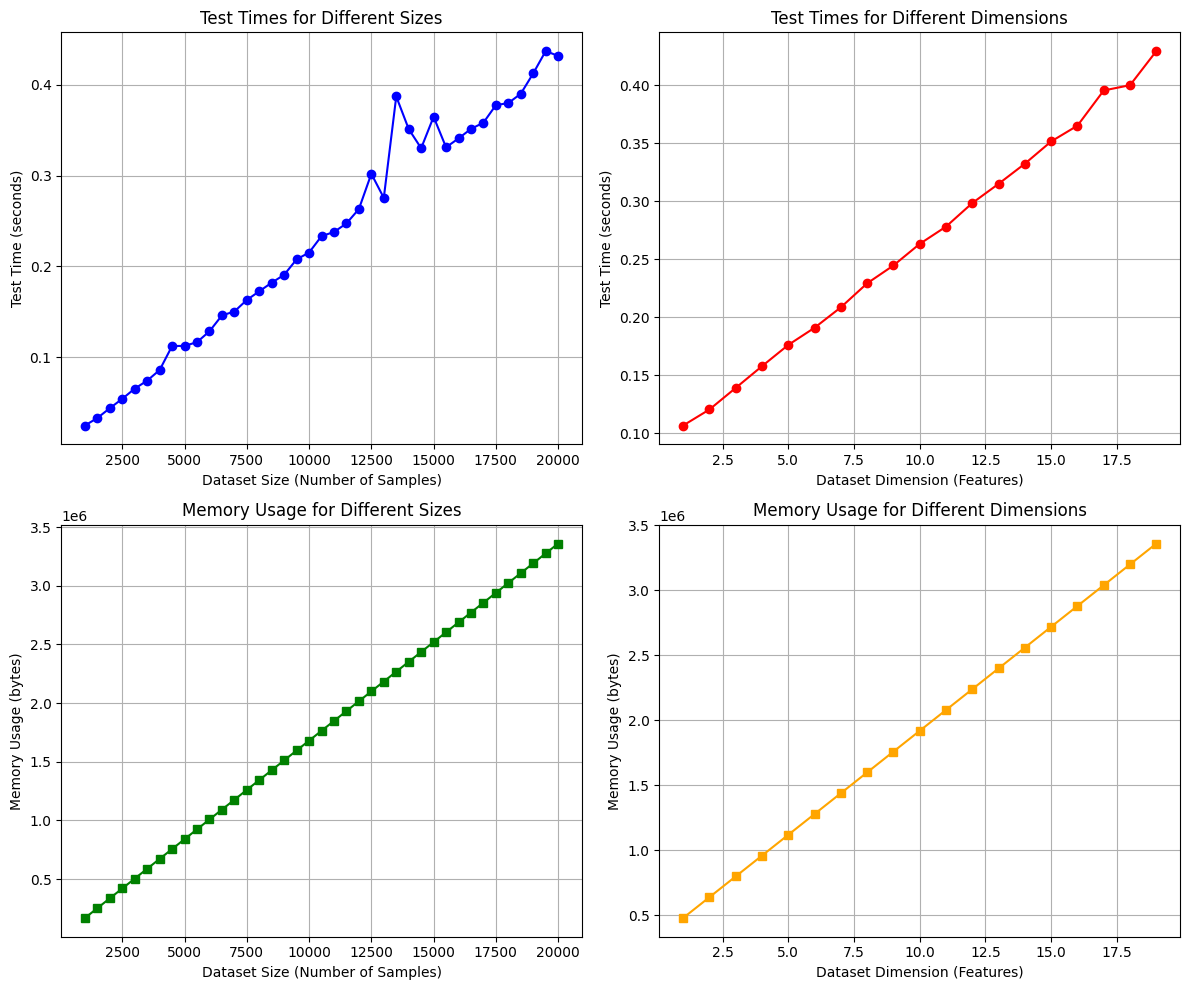

In [9]:
# Define dataset sizes for the x-axis in the first plot
dataset_sizes = list(range(1000, 20001, 500))

# Create a figure and a 2x2 grid of subplots (2 rows, 2 columns)
plt.figure(figsize=(12, 10))

# Plotting Test Times for Different Sizes (on the first subplot)
plt.subplot(2, 2, 1)
plt.plot(dataset_sizes, test_times_size, marker='o', color='b', label='Test Time for Different Sizes')
plt.xlabel('Dataset Size (Number of Samples)')
plt.ylabel('Test Time (seconds)')
plt.title('Test Times for Different Sizes')
plt.grid(True)

# Plotting Test Times for Different Dimensions (on the second subplot)
plt.subplot(2, 2, 2)
plt.plot(range(1, len(test_times_dim) + 1), test_times_dim, marker='o', color='r', label='Test Time for Different Dimensions')
plt.xlabel('Dataset Dimension (Features)')
plt.ylabel('Test Time (seconds)')
plt.title('Test Times for Different Dimensions')
plt.grid(True)

# Plotting Memory Usage for Different Sizes (on the third subplot)
plt.subplot(2, 2, 3)
plt.plot(dataset_sizes, total_memory_used_size, marker='s', color='g', label='Memory Usage for Different Sizes')
plt.xlabel('Dataset Size (Number of Samples)')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage for Different Sizes')
plt.grid(True)

# Plotting Memory Usage for Different Dimensions (on the fourth subplot)
plt.subplot(2, 2, 4)
plt.plot(range(1, len(total_memory_used_dim) + 1), total_memory_used_dim, marker='s', color='orange', label='Memory Usage for Different Dimensions')
plt.xlabel('Dataset Dimension (Features)')
plt.ylabel('Memory Usage (bytes)')
plt.title('Memory Usage for Different Dimensions')
plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjust layout to avoid overlap
plt.show()

### Time Complexity Analysis for Naive KNN

1. **Training Complexity**:  
   - Naive KNN has no explicit training phase; the complexity is $O(1)$.

2. **Testing Complexity**:  
   - For a query point, computing the distance to all $N$ data points takes $O(N \cdot D)$ time, where:
     - $N$ = number of points
     - $D$ = dimensionality

3. **Memory Complexity**:  
   - Memory is used to store all $N$ data points, so the space complexity is $O(N \cdot D)$.

# **KD Trees**

## **TRAIN**

In [10]:
# KD-Tree Node definition with a minimum leaf size constraint
class KDTreeNode:
    def __init__(self, points, left=None, right=None):
        self.points = points  # List of points at the node (only leaf nodes store multiple points)
        self.left = left
        self.right = right
        self.is_leaf = left is None and right is None  # Check if the node is a leaf

# Build the KD Tree recursively with a minimum leaf size constraint
def build_kd_tree(points, depth=0, leaf_size=40):
    """
    Recursively build the KD-Tree with a minimum leaf size constraint.
    
    Parameters:
    points (np.ndarray): Array of points to be included in the KD-Tree.
    depth (int): The current depth in the tree, used for alternating the split axis.
    leaf_size (int): Minimum number of points required to form a leaf node.
    
    Returns:
    KDTreeNode: Root node of the constructed KD-Tree.
    """
    n, k = points.shape  # n = number of points, k = number of dimensions

    # If we reach a minimum leaf size, create a leaf node containing all points in this subset
    if n <= leaf_size:
        return KDTreeNode(points)

    # Determine the axis (dimension) to split on; alternate axes for each depth
    axis = depth % k

    # Sort the points by the chosen axis and find the median point
    sorted_points = points[points[:, axis].argsort()]
    median_index = n // 2
    median_point = sorted_points[median_index]
    
    # Recursively build the left and right subtrees
    left_tree = build_kd_tree(sorted_points[:median_index], depth + 1, leaf_size)
    right_tree = build_kd_tree(sorted_points[median_index + 1:], depth + 1, leaf_size)
    
    # Create an internal node with the median point (does not store all points)
    node = KDTreeNode(np.array([median_point]), left_tree, right_tree)
    return node

import sys

# Function to calculate memory usage of the KD-Tree structure
def calculate_tree_memory(tree):
    """ Calculate memory used by the KD-Tree. """
    if tree is None:
        return 0
    memory = sys.getsizeof(tree)  # Memory used by the node itself
    if tree.is_leaf:
        memory += sys.getsizeof(tree.points)  # Memory used by the points in leaf nodes
    else:
        memory += calculate_tree_memory(tree.left)  # Recursively calculate memory for left subtree
        memory += calculate_tree_memory(tree.right)  # Recursively calculate memory for right subtree
    return memory

# Function to calculate memory usage for KNN search
def calculate_knn_memory(neighbors):
    """ Calculate memory used by the k-nearest neighbors. """
    return sys.getsizeof(neighbors)  # Size of the list storing the nearest neighbors


## **TEST**

In [11]:
# Function to compute the Euclidean distance between two points
def euclidean_distance(point1, point2):
    """
    Compute the Euclidean distance between two points.
    
    Parameters:
    point1 (np.ndarray): First point.
    point2 (np.ndarray): Second point.
    
    Returns:
    float: Euclidean distance between the points.
    """
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Recursive function to find the k-nearest neighbors in the KD-Tree
def knn_search_kd_tree(root, point, k, depth=0, best_neighbors=None):
    """
    Perform k-nearest neighbors search within the KD-Tree.
    
    Parameters:
    root (KDTreeNode): Root of the KD-Tree.
    point (np.ndarray): Query point for which we want the k-nearest neighbors.
    k (int): Number of nearest neighbors to find.
    depth (int): Current depth in the tree, used to determine the split axis.
    best_neighbors (list): List to store the k closest points and their distances.
    
    Returns:
    list: List of tuples containing the distance and the nearest neighbor point.
    """
    if best_neighbors is None:
        best_neighbors = []
        
    if root is None:
        return best_neighbors
    
    # If we're at a leaf node, check all points in the node
    if root.is_leaf:
        for leaf_point in root.points:
            dist = euclidean_distance(leaf_point, point)
            if len(best_neighbors) < k:
                best_neighbors.append((dist, leaf_point))
            else:
                # Sort neighbors by distance and maintain the closest k neighbors
                best_neighbors.sort()
                if dist < best_neighbors[-1][0]:
                    best_neighbors[-1] = (dist, leaf_point)
        return best_neighbors

    # Calculate the distance to the median point in the current node
    dist = euclidean_distance(root.points[0], point)
    if len(best_neighbors) < k:
        best_neighbors.append((dist, root.points[0]))
    else:
        best_neighbors.sort()
        if dist < best_neighbors[-1][0]:
            best_neighbors[-1] = (dist, root.points[0])

    # Determine the axis to compare based on depth
    axis = depth % len(point)

    # Traverse the appropriate subtree
    if point[axis] < root.points[0][axis]:
        best_neighbors = knn_search_kd_tree(root.left, point, k, depth + 1, best_neighbors)
        # Check the other subtree if necessary
        if len(best_neighbors) < k or abs(point[axis] - root.points[0][axis]) < best_neighbors[-1][0]:
            best_neighbors = knn_search_kd_tree(root.right, point, k, depth + 1, best_neighbors)
    else:
        best_neighbors = knn_search_kd_tree(root.right, point, k, depth + 1, best_neighbors)
        # Check the other subtree if necessary
        if len(best_neighbors) < k or abs(point[axis] - root.points[0][axis]) < best_neighbors[-1][0]:
            best_neighbors = knn_search_kd_tree(root.left, point, k, depth + 1, best_neighbors)

    return best_neighbors


import sys
import numpy as np

# Updated memory calculation function
def calculate_memory_usage(dataset, nearest_points, distances, tree):
    """
    Calculate memory usage of the dataset, KD-Tree, and KNN search.

    Parameters:
    - dataset: np.ndarray, the dataset being used.
    - nearest_points: list, the nearest neighbors found during the search.
    - distances: np.ndarray, the distances to the nearest neighbors.
    - tree: KDTreeNode, the root node of the KD-Tree.

    Returns:
    - total_memory: int, the total memory used by the dataset, KD-Tree, and KNN search.
    """
    # Memory used by the dataset
    dataset_memory = dataset.nbytes  # Scales with number of points and dimensions

    # Memory used by the K-nearest neighbors (distances and points)
    nearest_points_memory = sys.getsizeof(nearest_points)
    distances_memory = distances.nbytes if isinstance(distances, np.ndarray) else np.array(distances).nbytes

    # Memory used by the KD-Tree
    tree_memory = calculate_tree_memory(tree)

    # Total memory usage
    total_memory = dataset_memory + nearest_points_memory + distances_memory + tree_memory
    return total_memory


# Function to calculate memory used by the KD-Tree structure
def calculate_tree_memory(tree):
    """ Calculate memory used by the KD-Tree. """
    if tree is None:
        return 0
    memory = sys.getsizeof(tree)  # Memory used by the node itself
    if tree.is_leaf:
        memory += sys.getsizeof(tree.points)  # Memory used by the points in leaf nodes
    else:
        memory += calculate_tree_memory(tree.left)  # Recursively calculate memory for left subtree
        memory += calculate_tree_memory(tree.right)  # Recursively calculate memory for right subtree
    return memory


### Calculating

In [12]:
# Run KD-Tree KNN on datasets with varying sizes
print("Running KD-Tree KNN on datasets with varying sizes:\n")
test_times_size, train_times_size, k_nearest_points_size, memory_usage_size = [], [], [], []

for dataset in datasets_by_size:
    # Training: Build KD-Tree and measure time taken
    start_time = time.time()
    tree = build_kd_tree(dataset, leaf_size=40)  # Build KD-Tree for the dataset
    train_time = time.time() - start_time  # Calculate training time
    
    # Generate a random query point of matching dimension
    query_point_size = np.random.rand(dataset.shape[1])
    
    # Testing: Perform KNN search and measure time taken
    start_time = time.time()
    nearest_points = knn_search_kd_tree(tree, query_point_size, k=3)
    test_time = time.time() - start_time  # Calculate testing time
    
    # Calculate the Euclidean distances for nearest points
    distances = np.array([dist for dist, _ in nearest_points])
    
    # Calculate total memory used
    memory_used = calculate_memory_usage(dataset, nearest_points, distances, tree)
    
    # Store times, memory, and results
    train_times_size.append(train_time)
    test_times_size.append(test_time)
    memory_usage_size.append(memory_used)  # Total memory used
    k_nearest_points_size.append(nearest_points)

# Run KD-Tree KNN on datasets with varying dimensions
print("\nRunning KD-Tree KNN on datasets with varying dimensions:\n")
test_times_dim, train_times_dim, k_nearest_points_dim, memory_usage_dim = [], [], [], []

for dataset in datasets_by_dimension:
    # Training: Build KD-Tree and measure time taken
    start_time = time.time()
    tree = build_kd_tree(dataset, leaf_size=40)  # Build KD-Tree for the dataset
    train_time = time.time() - start_time  # Calculate training time
    
    # Generate a random query point of matching dimension
    query_point_dim = np.random.rand(dataset.shape[1])
    
    # Testing: Perform KNN search and measure time taken
    start_time = time.time()
    nearest_points = knn_search_kd_tree(tree, query_point_dim, k=3)
    test_time = time.time() - start_time  # Calculate testing time
    
    # Calculate the Euclidean distances for nearest points
    distances = np.array([dist for dist, _ in nearest_points])
    
    # Calculate total memory used
    memory_used = calculate_memory_usage(dataset, nearest_points, distances, tree)
    
    # Store times, memory, and results
    train_times_dim.append(train_time)
    test_times_dim.append(test_time)
    memory_usage_dim.append(memory_used)  # Total memory used
    k_nearest_points_dim.append(nearest_points)

# Print the collected results for analysis
print(f"\nTraining Times for Different Sizes: {train_times_size}")
print(f"Test Times for Different Sizes: {test_times_size}")
print(f"Memory Usage for Different Sizes: {memory_usage_size}")
print(f"\nTraining Times for Different Dimensions: {train_times_dim}")
print(f"Test Times for Different Dimensions: {test_times_dim}")
print(f"Memory Usage for Different Dimensions: {memory_usage_dim}")


Running KD-Tree KNN on datasets with varying sizes:


Running KD-Tree KNN on datasets with varying dimensions:


Training Times for Different Sizes: [0.0014996528625488281, 0.0024423599243164062, 0.0022649765014648438, 0.0025811195373535156, 0.0038793087005615234, 0.0050623416900634766, 0.004853248596191406, 0.004996538162231445, 0.005987644195556641, 0.007761240005493164, 0.009470701217651367, 0.008968353271484375, 0.010102987289428711, 0.010232210159301758, 0.010476827621459961, 0.011968374252319336, 0.012178182601928711, 0.012864351272583008, 0.012773513793945312, 0.012899398803710938, 0.017677783966064453, 0.018972158432006836, 0.018877744674682617, 0.02024555206298828, 0.02012777328491211, 0.021298646926879883, 0.023042917251586914, 0.021892786026000977, 0.024132966995239258, 0.023136615753173828, 0.02396225929260254, 0.024534225463867188, 0.024725675582885742, 0.02505779266357422, 0.026732206344604492, 0.027315378189086914, 0.11573362350463867, 0.02839064598083496, 0.031496286392

In [13]:
print("Length of dataset_sizes:", len(dataset_sizes))
print("Length of train_times_size:", len(train_times_size))
print("Length of TEST_times_size:", len(test_times_size))


Length of dataset_sizes: 39
Length of train_times_size: 39
Length of TEST_times_size: 39


### Plotting

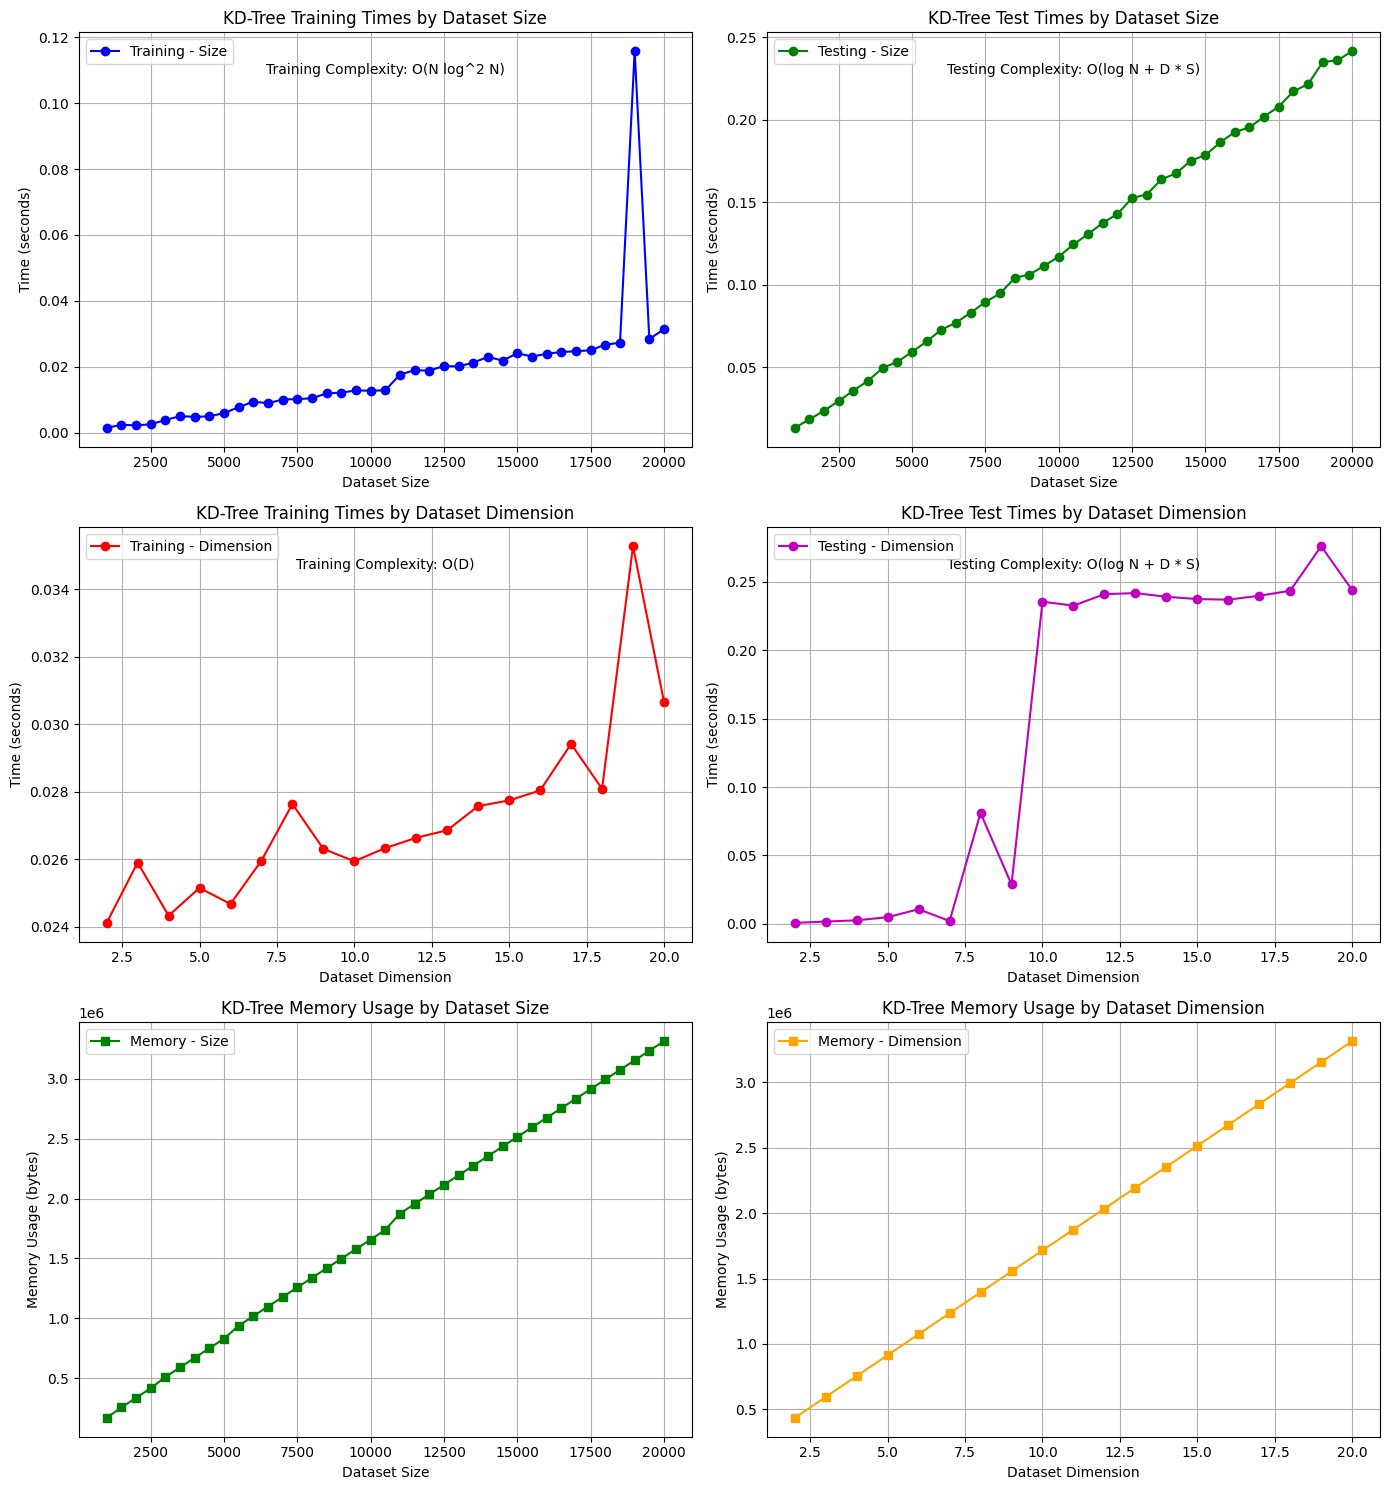

In [14]:
import matplotlib.pyplot as plt

# Sample dataset sizes and dimensions
dataset_sizes = list(range(1000, 20001, 500))  # Sizes from 1000 to 20000 with step 500
dataset_dimensions = [d.shape[1] for d in datasets_by_dimension]  # Extract dimensions from each dataset

# Create a figure and a 3x2 grid of subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# Plot for training times with varying dataset sizes
axes[0, 0].plot(dataset_sizes, train_times_size, marker='o', color='b', label="Training - Size")
axes[0, 0].set_title("KD-Tree Training Times by Dataset Size")
axes[0, 0].set_xlabel("Dataset Size")
axes[0, 0].set_ylabel("Time (seconds)")
axes[0, 0].grid(True)
axes[0, 0].legend()
axes[0, 0].text(0.5, 0.9, "Training Complexity: O(N log^2 N)", ha='center', transform=axes[0, 0].transAxes)

# Plot for test times with varying dataset sizes
axes[0, 1].plot(dataset_sizes, test_times_size, marker='o', color='g', label="Testing - Size")
axes[0, 1].set_title("KD-Tree Test Times by Dataset Size")
axes[0, 1].set_xlabel("Dataset Size")
axes[0, 1].set_ylabel("Time (seconds)")
axes[0, 1].grid(True)
axes[0, 1].legend()
axes[0, 1].text(0.5, 0.9, "Testing Complexity: O(log N + D * S)", ha='center', transform=axes[0, 1].transAxes)

# Plot for training times with varying dataset dimensions
axes[1, 0].plot(dataset_dimensions, train_times_dim, marker='o', color='r', label="Training - Dimension")
axes[1, 0].set_title("KD-Tree Training Times by Dataset Dimension")
axes[1, 0].set_xlabel("Dataset Dimension")
axes[1, 0].set_ylabel("Time (seconds)")
axes[1, 0].grid(True)
axes[1, 0].legend()
axes[1, 0].text(0.5, 0.9, "Training Complexity: O(D)", ha='center', transform=axes[1, 0].transAxes)

# Plot for test times with varying dataset dimensions
axes[1, 1].plot(dataset_dimensions, test_times_dim, marker='o', color='m', label="Testing - Dimension")
axes[1, 1].set_title("KD-Tree Test Times by Dataset Dimension")
axes[1, 1].set_xlabel("Dataset Dimension")
axes[1, 1].set_ylabel("Time (seconds)")
axes[1, 1].grid(True)
axes[1, 1].legend()
axes[1, 1].text(0.5, 0.9, "Testing Complexity: O(log N + D * S)", ha='center', transform=axes[1, 1].transAxes)

# Plot for memory usage with varying dataset sizes
axes[2, 0].plot(dataset_sizes, memory_usage_size, marker='s', color='g', label="Memory - Size")
axes[2, 0].set_title("KD-Tree Memory Usage by Dataset Size")
axes[2, 0].set_xlabel("Dataset Size")
axes[2, 0].set_ylabel("Memory Usage (bytes)")
axes[2, 0].grid(True)
axes[2, 0].legend()

# Plot for memory usage with varying dataset dimensions
axes[2, 1].plot(dataset_dimensions, memory_usage_dim, marker='s', color='orange', label="Memory - Dimension")
axes[2, 1].set_title("KD-Tree Memory Usage by Dataset Dimension")
axes[2, 1].set_xlabel("Dataset Dimension")
axes[2, 1].set_ylabel("Memory Usage (bytes)")
axes[2, 1].grid(True)
axes[2, 1].legend()

# Adjust layout to avoid overlapping elements
plt.tight_layout()
plt.show()


### Time Complexity Analysis

1. **Training Complexity**:  
   - KD-Tree construction has a complexity of $O(N\log^2 N)$, due to sorting at each level and having $O(\log N)$ levels.

2. **Testing Complexity**:  
   - Nearest neighbor queries take $O(\log N + D \cdot S)$ time, where:
     - $N$ = number of points
     - $D$ = dimensionality
     - $S$ = leaf node size (40 in this case)

3. **Memory Complexity**:  
   - Memory is used to store the tree structure and points, with a space complexity of $O(N \cdot D)$ for storing the data points and $O(N)$ for the tree structure itself.

# **LSH**

In [15]:
import numpy as np
import time
import psutil
import matplotlib.pyplot as plt

# Function to track memory usage
def get_memory_usage(dataset, nearest_points, distances):
    # Calculate memory usage of dataset (depends on number of points and dimensions)
    dataset_memory = dataset.nbytes  # This should already scale with both N and D
    
    # Calculate memory for K nearest points and distances
    nearest_points_memory = nearest_points.nbytes if isinstance(nearest_points, np.ndarray) else np.array(nearest_points).nbytes
    distances_memory = distances.nbytes if isinstance(distances, np.ndarray) else np.array(distances).nbytes
    
    # Total memory usage
    total_memory = dataset_memory + nearest_points_memory + distances_memory
    return total_memory

# LSH training and testing function
def train_and_test_lsh(dataset, k=3, num_projections=3):
    n_samples, n_features = dataset.shape
    
    # Training: Generate random projection matrix and compute hash codes
    start_time = time.time()
    random_projection_matrix = np.random.randn(n_features + 1, num_projections)  # +1 for bias term
    random_projection_matrix[:, -1] = 1  # Set the last column to 1 for bias term simplicity
    dataset_aug = np.hstack([np.ones((n_samples, 1)), dataset])  # Augment dataset with bias column
    projections = dataset_aug @ random_projection_matrix
    hash_codes = np.sign(projections)  # Calculate hash codes (brute-force)
    train_time = time.time() - start_time  # Measure training time
    
    # Generate a random query point with matching dimension
    query_point = np.random.rand(n_features)
    query_point_aug = np.hstack([1, query_point])  # Augment with bias term
    
    # Testing: Project query point and find nearest neighbors (Brute Force)
    start_time = time.time()
    query_projection = query_point_aug @ random_projection_matrix
    query_hash_code = np.sign(query_projection)
    
    # Brute-force Hamming distance calculation: compare all hash codes
    distances = np.sum(np.abs(hash_codes - query_hash_code), axis=1)  # Sum of Hamming distances
    nearest_indices = np.argsort(distances)[:k]  # Get indices of k-nearest points (brute force)
    
    test_time = time.time() - start_time  # Measure testing time
    
    # Calculate memory usage
    total_memory = get_memory_usage(dataset, hash_codes, distances)
    
    return train_time, test_time, total_memory

In [16]:
# Collect training and testing times and memory usage for size and dimension variations
train_times_size, test_times_size, total_mem_size = [], [], []
train_times_dim, test_times_dim, total_mem_dim = [], [], []

for dataset in datasets_by_size:
    train_time, test_time, total_memory = train_and_test_lsh(dataset, k=3, num_projections=3)
    train_times_size.append(train_time)
    test_times_size.append(test_time)
    total_mem_size.append(total_memory)

for dataset in datasets_by_dimension:
    train_time, test_time, total_memory = train_and_test_lsh(dataset, k=3, num_projections=3)
    train_times_dim.append(train_time)
    test_times_dim.append(test_time)
    total_mem_dim.append(total_memory)


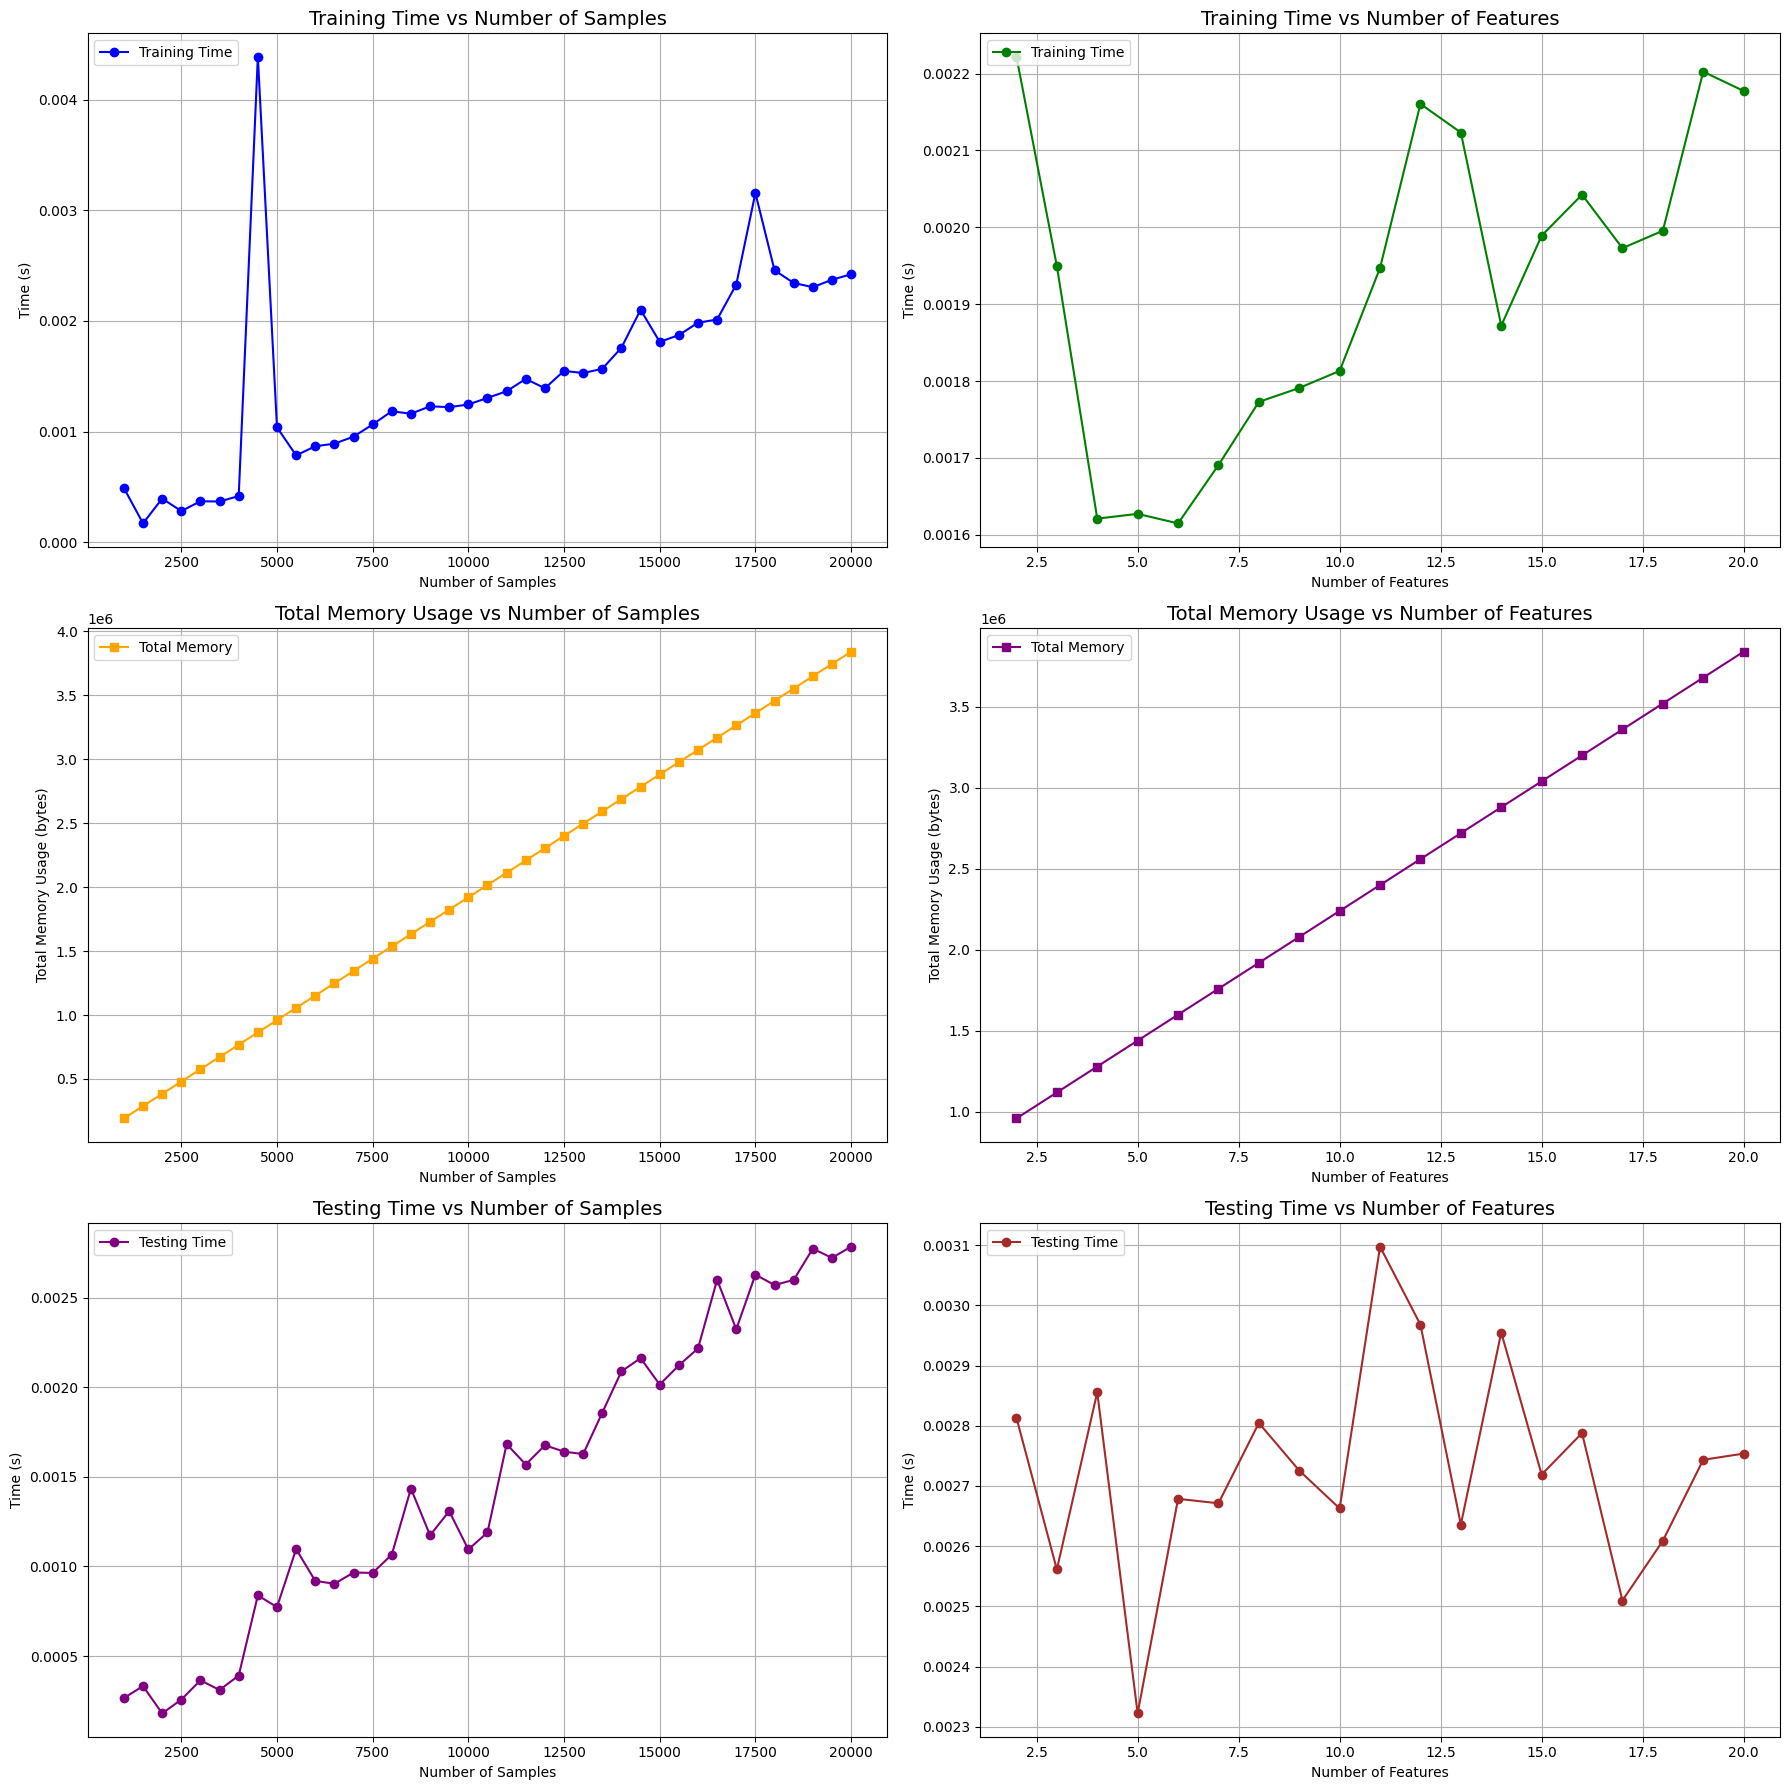

In [17]:
plt.figure(figsize=(18, 18))

# Top row - Training and Testing Times by Size and Dimension
plt.subplot(3, 2, 1)
plt.plot([len(d) for d in datasets_by_size], train_times_size, label="Training Time", color='b', marker='o')
plt.xlabel("Number of Samples")
plt.ylabel("Time (s)")
plt.title("Training Time vs Number of Samples", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(3, 2, 2)
plt.plot([d.shape[1] for d in datasets_by_dimension], train_times_dim, label="Training Time", color='g', marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Time (s)")
plt.title("Training Time vs Number of Features", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Second row - Total Memory Usage by Dataset Size and Dataset Dimension
plt.subplot(3, 2, 3)
plt.plot([len(d) for d in datasets_by_size], total_mem_size, label="Total Memory", color='orange', marker='s')
plt.xlabel("Number of Samples")
plt.ylabel("Total Memory Usage (bytes)")
plt.title("Total Memory Usage vs Number of Samples", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(3, 2, 4)
plt.plot([d.shape[1] for d in datasets_by_dimension], total_mem_dim, label="Total Memory", color='purple', marker='s')
plt.xlabel("Number of Features")
plt.ylabel("Total Memory Usage (bytes)")
plt.title("Total Memory Usage vs Number of Features", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Third row - Testing Times by Size and Dimension
plt.subplot(3, 2, 5)
plt.plot([len(d) for d in datasets_by_size], test_times_size, label="Testing Time", color='purple', marker='o')
plt.xlabel("Number of Samples")
plt.ylabel("Time (s)")
plt.title("Testing Time vs Number of Samples", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

plt.subplot(3, 2, 6)
plt.plot([d.shape[1] for d in datasets_by_dimension], test_times_dim, label="Testing Time", color='brown', marker='o')
plt.xlabel("Number of Features")
plt.ylabel("Time (s)")
plt.title("Testing Time vs Number of Features", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True)

# Bottom row - Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()

### Time and Memory Complexity of LSH

- **Training Time**:  
  Training involves hashing \(n\) data points with \(k\) hash functions, each taking \(O(d)\) for projection. Hence, the training time complexity is:
  $$
  O(n \cdot k \cdot d)
  $$

- **Testing Time**:  
  Testing involves hashing the query point with \(k\) hash functions (\(O(d)\) time), followed by checking all \(n\) data points. The testing time complexity is:
  $$
  O(k \cdot d + n)
  $$

- **Memory Complexity**:  
  Memory is used to store the hash codes of \(n\) data points, each requiring \(O(k)\) space. The memory complexity is:
  $$
  O(n \cdot k)
  $$

Where:
- \(n\) = number of data points,
- \(k\) = number of hash functions,
- \(d\) = dimensionality of the data.

# **Visvalization in 2D space**

In [18]:
# Define the dataset
dataset_2d = np.array([
    [1, 9], [2, 3], [4, 1], [3, 7], [5, 4], 
    [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]
])
query_point = np.array([6.1,4.5])


## **Naive KNN**

Test Time: [0.0001537799835205078]
Nearest Points: [array([[5, 4]])]


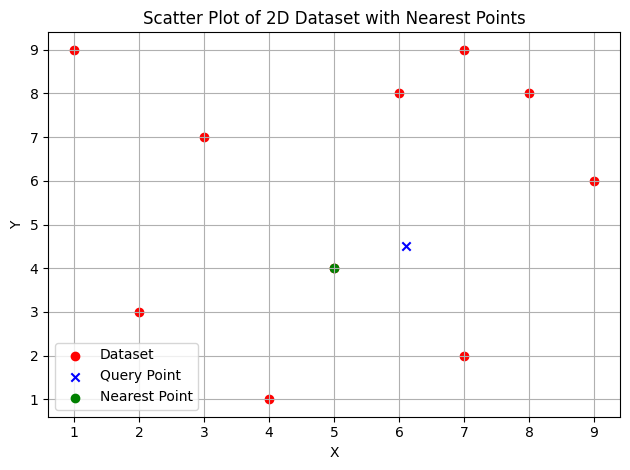

In [19]:

test_time, nearest_points = naive_KNN([dataset_2d], 1, query_point)

print("Test Time:", test_time)
print("Nearest Points:", nearest_points)

# Plot the 2D dataset
plt.scatter(dataset_2d[:, 0], dataset_2d[:, 1], color="red", label="Dataset")

# Plot the query point
plt.scatter(query_point[0], query_point[1], color="blue", label="Query Point", marker='x')

# Plot the nearest points
for point in nearest_points[0]:  # Assuming nearest_points is a list of arrays
    plt.scatter(point[0], point[1], color="green", label="Nearest Point", marker='o')

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of 2D Dataset with Nearest Points')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

##  **KD Trees**

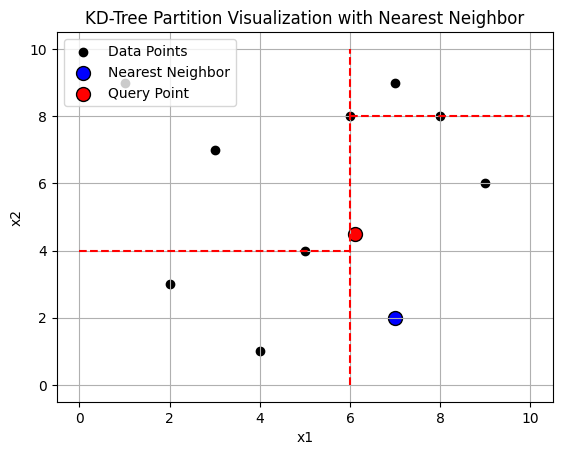

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

# Define the dataset
dataset_2d = np.array([
    [1, 9], [2, 3], [4, 1], [3, 7], [5, 4], 
    [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]
])
query_point = np.array([6.1,4.5])

# KD-Tree Node definition with minimum leaf size constraint
class KDTreeNode:
    def __init__(self, point=None, points=None, left=None, right=None, axis=None):
        self.point = point  # Single point at the node (for internal nodes)
        self.points = points  # Multiple points for leaf nodes (if it's a leaf)
        self.left = left
        self.right = right
        self.axis = axis  # Axis along which the node splits

# Build the KD Tree recursively with a minimum leaf size constraint
def build_kd_tree(points, depth=0, leaf_size=2, split_lines=None):
    n, k = points.shape  # n = number of points, k = number of dimensions

    # Initialize split_lines if not provided
    if split_lines is None:
        split_lines = []

    # If we reach a minimum leaf size, return a leaf node with no splits
    if n <= leaf_size:
        return KDTreeNode(points=points), split_lines

    # Determine the axis (dimension) to split on; alternate axes for each depth
    axis = depth % k

    # Sort points by the chosen axis and find the median point
    sorted_points = points[points[:, axis].argsort()]
    median_index = n // 2
    median_point = sorted_points[median_index]
    
    # Record the split line for visualization
    split_lines.append((median_point[axis], axis))

    # Recursively build left and right subtrees
    left_tree, _ = build_kd_tree(sorted_points[:median_index], depth + 1, leaf_size, split_lines)
    right_tree, _ = build_kd_tree(sorted_points[median_index + 1:], depth + 1, leaf_size, split_lines)
    
    # Create an internal node with the median point
    node = KDTreeNode(point=median_point, left=left_tree, right=right_tree, axis=axis)
    return node, split_lines

def plot_kd_tree(node, x_min, x_max, y_min, y_max, depth=0):
    # Check if the node is None or a leaf node with points
    if node is None:
        return

    # If it's a leaf node, it contains points, and we don't plot split lines
    if node.points is not None:
        return

    point = node.point
    axis = node.axis

    if axis == 0:  # vertical line (splitting along x-axis)
        # Plot a line segment at the x-coordinate of the split point, bounded by the current y range
        plt.plot([point[0], point[0]], [y_min, y_max], 'r--')
        plot_kd_tree(node.left, x_min, point[0], y_min, y_max, depth + 1)
        plot_kd_tree(node.right, point[0], x_max, y_min, y_max, depth + 1)
    else:  # horizontal line (splitting along y-axis)
        # Plot a line segment at the y-coordinate of the split point, bounded by the current x range
        plt.plot([x_min, x_max], [point[1], point[1]], 'r--')
        plot_kd_tree(node.left, x_min, x_max, y_min, point[1], depth + 1)
        plot_kd_tree(node.right, x_min, x_max, point[1], y_max, depth + 1)


# Nearest Neighbor Search in KD-Tree without backtracking
def kd_tree_nearest_neighbor(node, query_point, k=1, depth=0):
    k_dim = query_point.shape[0]
    axis = depth % k_dim

    # Traverse down the tree until reaching a leaf node
    while node.points is None:
        # Decide the primary branch to follow based on the query point and splitting axis
        if query_point[axis] < node.point[axis]:
            node = node.left
        else:
            node = node.right
        depth += 1
        axis = depth % k_dim

    # Now `node` is a leaf node with `node.points`
    # Calculate distances to each point in this leaf node
    distances = [(np.linalg.norm(query_point - point), point) for point in node.points]
    
    # Get the k nearest points in this leaf node
    nearest_points = heapq.nsmallest(k, distances)
    
    return nearest_points


# Set up the query point


# Build the KD-Tree and capture split lines for visualization
kd_tree_root, split_lines = build_kd_tree(dataset_2d, leaf_size=2)

# Find the nearest neighbors
k = 1 # Number of nearest neighbors to find
nearest_points_with_distances = kd_tree_nearest_neighbor(kd_tree_root, query_point, k)
nearest_points = [point for _, point in nearest_points_with_distances]  # Extract only the points

# Plotting
plt.scatter(dataset_2d[:, 0], dataset_2d[:, 1], color='black', label='Data Points')
plot_kd_tree(kd_tree_root, 0, 10, 0, 10)  # Set axis limits based on dataset range

# Highlight nearest neighbors
for point in nearest_points:
    plt.scatter(point[0], point[1], color='blue', s=100, edgecolors='black', label='Nearest Neighbor')

# Highlight query point
plt.scatter(query_point[0], query_point[1], color='red', s=100, edgecolors='black', label='Query Point')

plt.xlabel("x1")
plt.ylabel("x2")
plt.title("KD-Tree Partition Visualization with Nearest Neighbor")
plt.grid(True)
plt.legend(loc="upper left")
plt.show()


## **LSH**

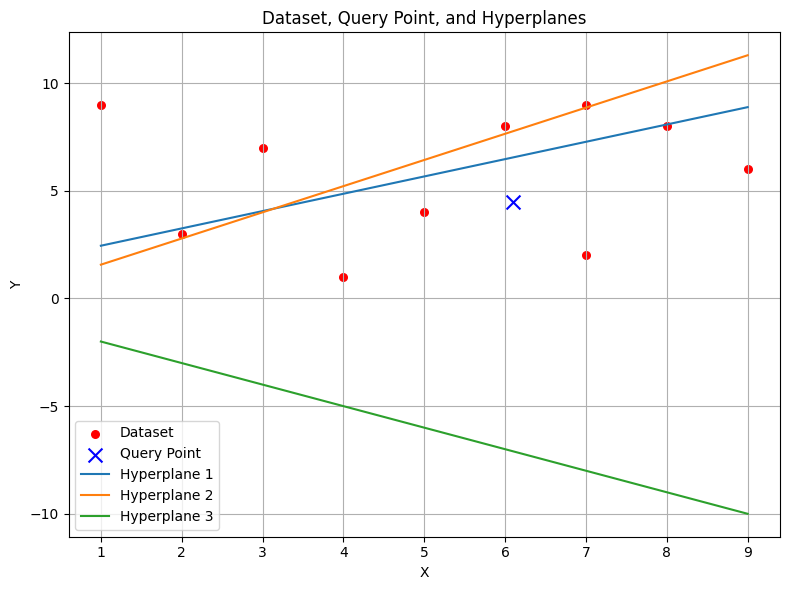

Hyperplane coefficients (R):
 [[-1.88973671 -0.41359218  1.        ]
 [-0.92412667 -1.42159783  1.        ]
 [ 1.14886176  1.1694284   1.        ]]


In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(35)

# Define the dataset
dataset_2d = np.array([
    [1, 9], [2, 3], [4, 1], [3, 7], [5, 4], 
    [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]
])
query_point = np.array([6.1, 4.5])

# Number of hyperplanes
P = 3  

# Random coefficients for the hyperplanes, with one extra row for intercept
R = np.random.randn(3, P)
R[:, 2] = 1  # Set the third column's third row to 1 to simplify plotting

# Plotting the dataset and query point
plt.figure(figsize=(8, 6))

# Plot the dataset points
plt.scatter(dataset_2d[:, 0], dataset_2d[:, 1], color="red", label="Dataset", s=30)

# Plot the query point
plt.scatter(query_point[0], query_point[1], color="blue", label="Query Point", marker='x', s=100)

# Plot the hyperplanes
x_range = np.array([dataset_2d[:, 0].min(), dataset_2d[:, 0].max()])  # x-axis range based on data
for i in range(P):
    # Calculate corresponding y-values for the hyperplane
    x2 = (-R[0, i] - R[1, i] * x_range) / R[2, i]
    plt.plot(x_range, x2, label=f'Hyperplane {i+1}')

# Labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dataset, Query Point, and Hyperplanes')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()
print("Hyperplane coefficients (R):\n", R)


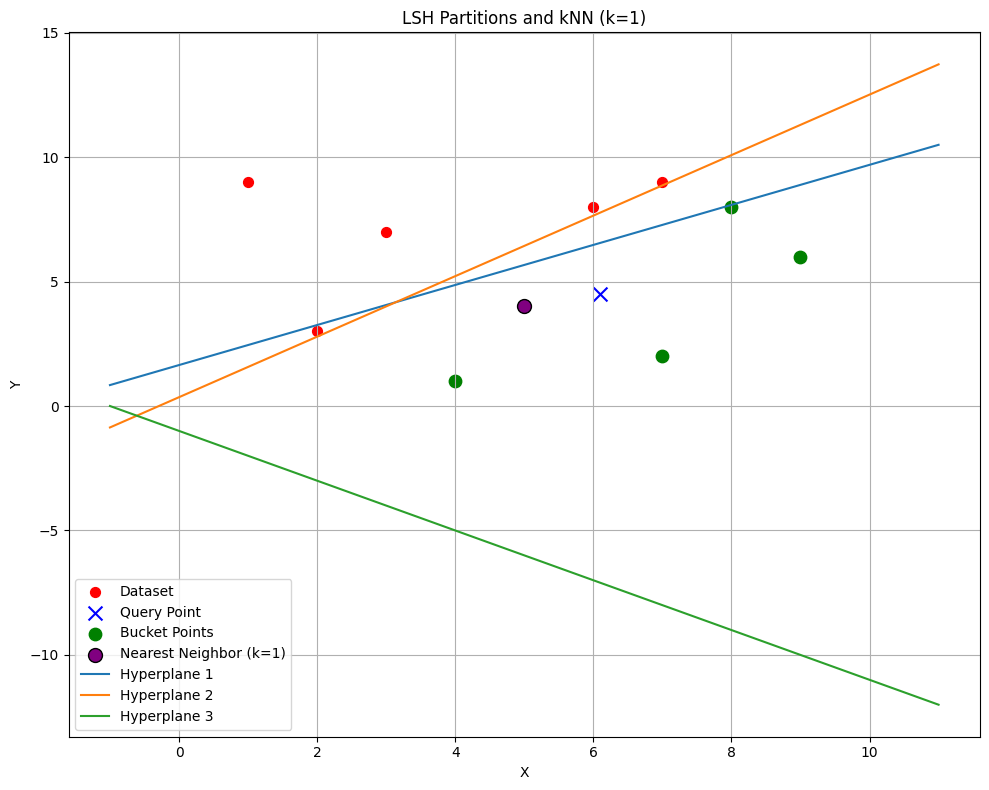

Nearest neighbor to the query point in the same bucket: [5 4]


In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset
dataset_2d = np.array([
    [1, 9], [2, 3], [4, 1], [3, 7], [5, 4], 
    [6, 8], [7, 2], [8, 8], [7, 9], [9, 6]
])
query_point = np.array([6.1, 4.5])

P = 3
np.random.seed(35)
R = np.random.randn(dataset_2d.shape[1] + 1, P)  # +1 for bias term

# For simplicity, set R[:, 2] = 1 to make it easier to plot
R[:, 2] = 1

# Function to determine bucket assignment
def assign_to_bucket(point, R):
    """
    Assign a point to a bucket by checking on which side of each hyperplane it lies.
    Returns a binary hash for the bucket assignment.
    """
    return np.sign(R[0] + R[1] * point[0] + R[2] * point[1])

# Bucket assignment for query point and dataset
query_bucket = assign_to_bucket(query_point, R)
buckets = np.array([assign_to_bucket(point, R) for point in dataset_2d])

# Find points in the same bucket as the query point
bucket_points = dataset_2d[np.all(buckets == query_bucket, axis=1)]

# kNN within the bucket for k = 1
if bucket_points.size > 0:
    distances = np.linalg.norm(bucket_points - query_point, axis=1)  # Euclidean distance
    nearest_idx = np.argmin(distances)
    nearest_point = bucket_points[nearest_idx]
else:
    nearest_point = None

# Plotting
plt.figure(figsize=(10, 8))

# Plot dataset and query point
plt.scatter(dataset_2d[:, 0], dataset_2d[:, 1], color="red", label="Dataset", s=50)
plt.scatter(query_point[0], query_point[1], color="blue", label="Query Point", marker='x', s=100)

# Highlight bucket points
if bucket_points.size > 0:
    plt.scatter(bucket_points[:, 0], bucket_points[:, 1], color="green", label="Bucket Points", s=80)

# Highlight the nearest neighbor
if nearest_point is not None:
    plt.scatter(nearest_point[0], nearest_point[1], color="purple", label="Nearest Neighbor (k=1)", s=100, edgecolors='black')

# Plot hyperplanes
x_range = np.linspace(dataset_2d[:, 0].min() - 2, dataset_2d[:, 0].max() + 2, 500)

for i in range(R.shape[1]):
    if abs(R[2, i]) > 1e-6:  # Avoid division by zero
        x2 = (-R[0, i] - R[1, i] * x_range) / R[2, i]
        plt.plot(x_range, x2, label=f'Hyperplane {i+1}')
    else:
        # Vertical hyperplane case
        x_fixed = -R[0, i] / R[1, i] if abs(R[1, i]) > 1e-6 else 0
        plt.axvline(x=x_fixed, label=f'Hyperplane {i+1} (Vertical)', linestyle='--')

# Labels and legend
plt.xlabel('X')
plt.ylabel('Y')
plt.title('LSH Partitions and kNN (k=1)')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

# Output the nearest neighbor
if nearest_point is not None:
    print(f"Nearest neighbor to the query point in the same bucket: {nearest_point}")
else:
    print("No points in the same bucket as the query point.")
